# Graph Coloring Problem

## Map Utility

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate

shapefile = "PAK_adm1.shp"
provinces = gpd.read_file(shapefile)

province_names_df = pd.read_csv("PAK_adm1.csv")

provinces['index'] = range(len(provinces))
province_names_df['index'] = range(len(province_names_df))

provinces = pd.merge(provinces, province_names_df, on='index')

# Apply the colors to the provinces
def displaymap(solution):
      ax = provinces.plot()
      # Add province names as annotations
      for idx, row in provinces.iterrows():
        centroid = row.geometry.centroid
        ax.text(centroid.x, centroid.y, row['NAME_1'], fontsize=8, ha='center')
    
      for province, color in solution.items():
        provinces[provinces['NAME_1'] == province].plot(ax=ax, color=color)
  
      plt.title("Provinces of Pakistan Map")
      plt.axis('off')  
      plt.show()


## Pakistan Provinces Map

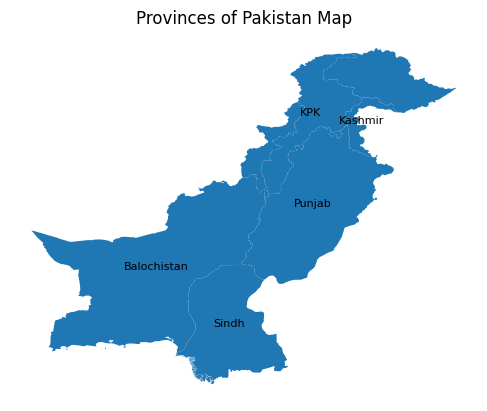

In [2]:
variables = ['Punjab', 'Sindh', 'KPK', 'Balochistan', 'Kashmir']
domains = {var: ['yellow', 'orange', 'purple'] for var in variables}

constraints = [
    ('Punjab', 'Sindh'), ('Punjab', 'KPK'), ('Punjab', 'Balochistan'), ('Punjab', 'Kashmir'), ('Sindh', 'Balochistan'),
    ('KPK', 'Kashmir'), ('KPK', 'Balochistan')
]
displaymap({})

## Naïve search

+-------------+----------+
| Cities      | Colors   |
+=============+==========+
| Punjab      | yellow   |
+-------------+----------+
| Sindh       | orange   |
+-------------+----------+
| KPK         | orange   |
+-------------+----------+
| Balochistan | purple   |
+-------------+----------+
| Kashmir     | purple   |
+-------------+----------+


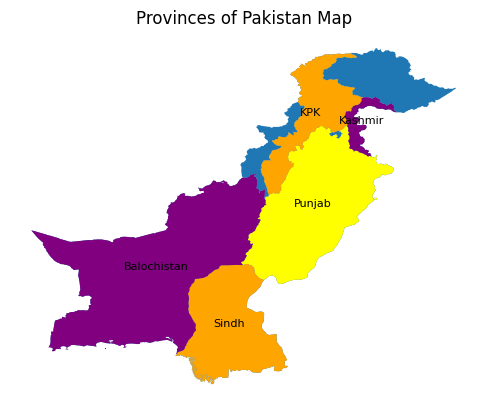

In [25]:
def is_consistent(variable, value, assignment, constraints):
    for constraint in constraints:
        if variable in constraint and constraint[constraint.index(variable) - 1] in assignment:
            neighbor = constraint[constraint.index(variable) - 1]
            if assignment[neighbor] == value:
                return False
    return True

def naive_search(variables, domains, constraints, assignment={}):
    if len(assignment) == len(variables):
        return assignment

    unassigned_var = next(var for var in variables if var not in assignment)
    for value in domains[unassigned_var]:
        if is_consistent(unassigned_var, value, assignment, constraints):
            new_assignment = assignment.copy()
            new_assignment[unassigned_var] = value
            result = naive_search(variables, domains, constraints, new_assignment)
            if result is not None:
                return result
    return None

solutionnaive = naive_search(variables, domains, constraints)
solution_listnaive = [(city, color) for city, color in solutionnaive.items()]
print(tabulate(solution_listnaive, headers=["Cities", "Colors"], tablefmt="grid"))

displaymap(solutionnaive)


## Arc Consistency

In [4]:
def revise(domains, constraints, Xi, Xj):
    revised = False
    for x in domains[Xi]:
        consistent = True
        for y in domains[Xj]:
            if (Xi, x, Xj, y) in constraints:
                consistent = False
                break
        if consistent:
            domains[Xi].remove(x)
            revised = True
    return revised

def AC3(variables, domains, constraints):
    queue = []
    for Xi in variables:
        for Xj in variables:
            if (Xi, Xj) in constraints or (Xj, Xi) in constraints:
                queue.append((Xi, Xj))

    while queue:
        Xi, Xj = queue.pop(0)
        if revise(domains, constraints, Xi, Xj):
            if not domains[Xi]:
                return False
            for Xk in variables:
                if (Xk, Xi) in constraints:
                    queue.append((Xk, Xi))
    return True


if AC3(variables, domains, constraints):
    print("Arc consistency applied successfully.")
    print("Revised domains:")
    for var, domain in domains.items():
        print(f"{var}: {domain}")
else:
    print("No solution exists after applying arc consistency.")


No solution exists after applying arc consistency.


## Backtracking Search

+-------------+----------+
| Cities      | Colors   |
+=============+==========+
| Punjab      | yellow   |
+-------------+----------+
| Sindh       | orange   |
+-------------+----------+
| KPK         | orange   |
+-------------+----------+
| Balochistan | purple   |
+-------------+----------+
| Kashmir     | purple   |
+-------------+----------+


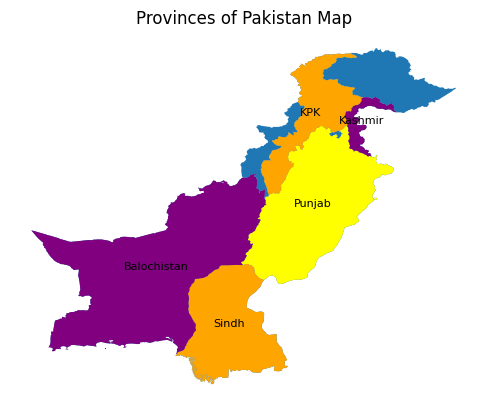

In [3]:

def isconsistent(var, value, assignment, constraints):
    for neighbor in constraints:
        if neighbor[0] == var and neighbor[1] in assignment and assignment[neighbor[1]] == value:
            return False
        if neighbor[1] == var and neighbor[0] in assignment and assignment[neighbor[0]] == value:
            return False
    return True


def backtrack(assignment):
    if len(assignment) == len(variables):
        return assignment

    var = selectunassignedvariable(assignment)
    for value in domains[var]:
        if isconsistent(var, value, assignment, constraints):
            assignment[var] = value
            result = backtrack(assignment)
            if result is not None:
                return result
            del assignment[var]
    return None
def selectunassignedvariable(assignment):
    for var in variables:
        if var not in assignment:
            return var
    return None
coloring={}
solutionbacktrack = backtrack(coloring)    


solution_list = [(city, color) for city, color in solutionbacktrack.items()]


print(tabulate(solution_list, headers=["Cities", "Colors"], tablefmt="grid"))

displaymap(solutionbacktrack)


## Backtracking Search with Heuristics

### Minimum Remaining Values (MRV)

Solution using MRV heuristic:
+-------------+----------+
| Cities      | Colors   |
+=============+==========+
| Punjab      | yellow   |
+-------------+----------+
| Sindh       | orange   |
+-------------+----------+
| KPK         | orange   |
+-------------+----------+
| Balochistan | purple   |
+-------------+----------+
| Kashmir     | purple   |
+-------------+----------+


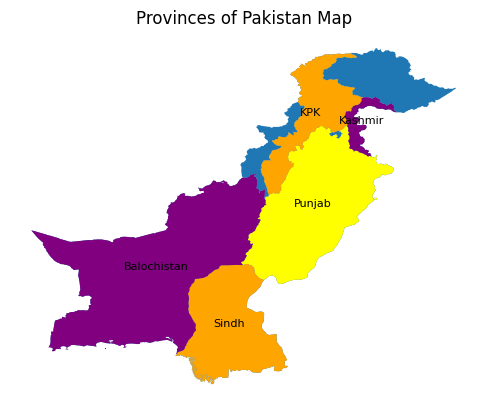

In [ ]:
def is_consistent(var, value, assignment, constraints):
    for neighbor in constraints:
        if neighbor[0] == var and neighbor[1] in assignment and assignment[neighbor[1]] == value:
            return False
        if neighbor[1] == var and neighbor[0] in assignment and assignment[neighbor[0]] == value:
            return False
    return True

def select_unassigned_variable_mrv(assignment, variables, domains):
    unassigned_variables = [var for var in variables if var not in assignment]
    # MRV: Choose the variable with the fewest remaining legal values in its domain
    return min(unassigned_variables, key=lambda var: len(domains[var]))

def backtrack_mrv(assignment, variables, domains, constraints):
    if len(assignment) == len(variables):
        return assignment

    var = select_unassigned_variable_mrv(assignment, variables, domains)
    for value in domains[var]:
        if is_consistent(var, value, assignment, constraints):
            assignment[var] = value
            result = backtrack_mrv(assignment, variables, domains, constraints)
            if result is not None:
                return result
            del assignment[var]
    return None

coloring_mrv = {}
solution_backtrack_mrv = backtrack_mrv(coloring_mrv, variables, domains, constraints)

if solution_backtrack_mrv is not None:
    solution_list_mrv = [(city, color) for city, color in solution_backtrack_mrv.items()]
    print("Solution using MRV heuristic:")
    print(tabulate(solution_list_mrv, headers=["Cities", "Colors"], tablefmt="grid"))
    displaymap(solution_backtrack_mrv)
    
else:
    print("No solution found using MRV heuristic.")

### Least Constraining Value (LCV)

Solution using LCV heuristic:
+-------------+----------+
| Cities      | Colors   |
+=============+==========+
| Punjab      | yellow   |
+-------------+----------+
| Sindh       | orange   |
+-------------+----------+
| KPK         | orange   |
+-------------+----------+
| Balochistan | purple   |
+-------------+----------+
| Kashmir     | purple   |
+-------------+----------+


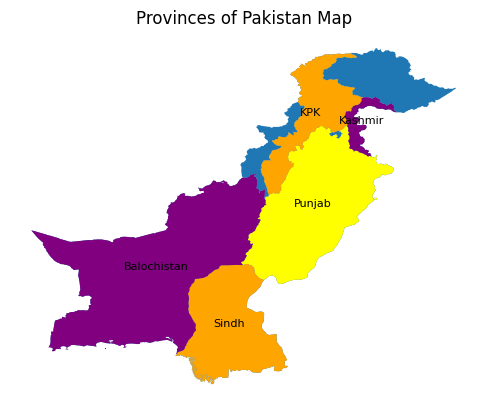

In [ ]:
def is_consistent(var, value, assignment, constraints):
    for neighbor in constraints:
        if neighbor[0] == var and neighbor[1] in assignment and assignment[neighbor[1]] == value:
            return False
        if neighbor[1] == var and neighbor[0] in assignment and assignment[neighbor[0]] == value:
            return False
    return True


def order_values_lcv(var, assignment, domains, constraints):
    # LCV: Choose the value that rules out the fewest values in the remaining variables
    def count_remaining_values(value):
        count = 0
        for neighbor_var in domains.keys():
            if neighbor_var != var and neighbor_var not in assignment:
                count += sum(1 for neighbor_value in domains[neighbor_var] if not is_consistent(neighbor_var, neighbor_value, assignment, constraints))
        return count

    return sorted(domains[var], key=count_remaining_values)

def backtrack_lcv(assignment, variables, domains, constraints):
    if len(assignment) == len(variables):
        return assignment

    var = selectunassignedvariable(assignment)
    for value in order_values_lcv(var, assignment, domains, constraints):
        if is_consistent(var, value, assignment, constraints):
            assignment[var] = value
            result = backtrack_lcv(assignment, variables, domains, constraints)
            if result is not None:
                return result
            del assignment[var]
    return None

coloring_lcv = {}
solution_backtrack_lcv = backtrack_lcv(coloring_lcv, variables, domains, constraints)

if solution_backtrack_lcv is not None:
    solution_list_lcv = [(city, color) for city, color in solution_backtrack_lcv.items()]
    print("Solution using LCV heuristic:")
    print(tabulate(solution_list_lcv, headers=["Cities", "Colors"], tablefmt="grid"))
    displaymap(solution_backtrack_lcv)
    
    
else:
    print("No solution found using LCV heuristic.")


## Forward Checking

Solution using Forward Checking:
+-------------+----------+
| Cities      | Colors   |
+=============+==========+
| Punjab      | yellow   |
+-------------+----------+
| Sindh       | orange   |
+-------------+----------+
| KPK         | orange   |
+-------------+----------+
| Balochistan | purple   |
+-------------+----------+
| Kashmir     | purple   |
+-------------+----------+


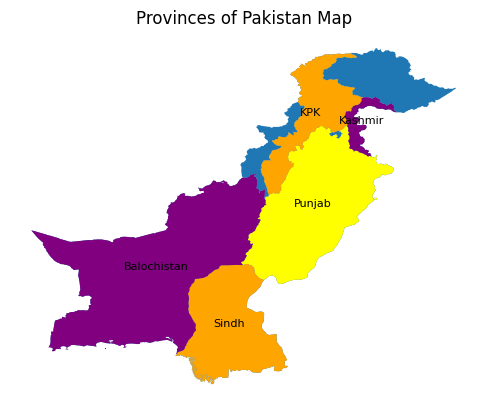

In [ ]:
def is_consistent(var, value, assignment, constraints):
    for neighbor in constraints:
        if neighbor[0] == var and neighbor[1] in assignment and assignment[neighbor[1]] == value:
            return False
        if neighbor[1] == var and neighbor[0] in assignment and assignment[neighbor[0]] == value:
            return False
    return True

def select_unassigned_variable(assignment, variables, domains):
    for var in variables:
        if var not in assignment:
            return var
    return None

def forward_checking(var, value, assignment, domains, constraints):
    for neighbor_var in domains.keys():
        if neighbor_var != var and neighbor_var not in assignment:
            for neighbor_value in list(domains[neighbor_var]):
                if not is_consistent(neighbor_var, neighbor_value, assignment, constraints):
                    domains[neighbor_var].remove(neighbor_value)
    return domains

def backtrack_forward_checking(assignment, variables, domains, constraints):
    if len(assignment) == len(variables):
        return assignment

    var = select_unassigned_variable(assignment, variables, domains)
    for value in domains[var]:
        if is_consistent(var, value, assignment, constraints):
            assignment[var] = value
            domains_copy = {key: value[:] for key, value in domains.items()}  
            forward_checking(var, value, assignment, domains_copy, constraints)
            result = backtrack_forward_checking(assignment, variables, domains_copy, constraints)
            if result is not None:
                return result
            del assignment[var]
    return None

coloring_forward_checking = {}
solution_backtrack_forward_checking = backtrack_forward_checking(coloring_forward_checking, variables, domains, constraints)

if solution_backtrack_forward_checking is not None:
    solution_list_forward_checking = [(city, color) for city, color in solution_backtrack_forward_checking.items()]
    print("Solution using Forward Checking:")
    print(tabulate(solution_list_forward_checking, headers=["Cities", "Colors"], tablefmt="grid"))
    displaymap(solution_backtrack_forward_checking)
else:
    print("No solution found using Forward Checking.")
